In [1]:
import pyuvdata
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

In [ ]:
beam_path = "/lustre/rbyrne/LWA_10to100_MROsoil_efields.fits"

In [3]:
beam = pyuvdata.UVBeam()
beam.read(beam_path)
beam.select(axis2_inds=np.where(beam.axis2_array <= np.pi / 2)[0])  # Use values out to the horizon only
beam.peak_normalize()  # Set beam value to 1 at zenith

In [4]:
print(f"Frequencies (Hz): {beam.freq_array}")

Frequencies (Hz): [1.0e+07 1.1e+07 1.2e+07 1.3e+07 1.4e+07 1.5e+07 1.6e+07 1.7e+07 1.8e+07
 1.9e+07 2.0e+07 2.1e+07 2.2e+07 2.3e+07 2.4e+07 2.5e+07 2.6e+07 2.7e+07
 2.8e+07 2.9e+07 3.0e+07 3.1e+07 3.2e+07 3.3e+07 3.4e+07 3.5e+07 3.6e+07
 3.7e+07 3.8e+07 3.9e+07 4.0e+07 4.1e+07 4.2e+07 4.3e+07 4.4e+07 4.5e+07
 4.6e+07 4.7e+07 4.8e+07 4.9e+07 5.0e+07 5.1e+07 5.2e+07 5.3e+07 5.4e+07
 5.5e+07 5.6e+07 5.7e+07 5.8e+07 5.9e+07 6.0e+07 6.1e+07 6.2e+07 6.3e+07
 6.4e+07 6.5e+07 6.6e+07 6.7e+07 6.8e+07 6.9e+07 7.0e+07 7.1e+07 7.2e+07
 7.3e+07 7.4e+07 7.5e+07 7.6e+07 7.7e+07 7.8e+07 7.9e+07 8.0e+07 8.1e+07
 8.2e+07 8.3e+07 8.4e+07 8.5e+07 8.6e+07 8.7e+07 8.8e+07 8.9e+07 9.0e+07
 9.1e+07 9.2e+07 9.3e+07 9.4e+07 9.5e+07 9.6e+07 9.7e+07 9.8e+07 9.9e+07
 1.0e+08]


In [5]:
def make_polar_contour_plot(
    ax,
    plot_vals,
    az_vals,
    za_vals,
    vmin=-1,
    vmax=1,
    cyclic_colorbar=False,
    ncontours=11,
):

    if cyclic_colorbar:
        use_cmap = matplotlib.cm.get_cmap("twilight_shifted").copy()
    else:
        if vmin >= 0:
            use_cmap = matplotlib.cm.get_cmap("inferno").copy()
        else:
            use_cmap = matplotlib.cm.get_cmap("Spectral").copy()
    use_cmap.set_bad(color="whitesmoke")

    # Fill in plotting gap by copying az=0 values to az=2Pi
    az_zeros = np.where(az_vals == 0.0)
    az_vals = np.concatenate(
        (az_vals, (az_vals[az_zeros[0], az_zeros[1]] + 2 * np.pi)[np.newaxis, :]),
        axis=0,
    )
    za_vals = np.concatenate(
        (za_vals, (za_vals[az_zeros[0], az_zeros[1]])[np.newaxis, :]), axis=0
    )
    plot_vals = np.concatenate(
        (plot_vals, (plot_vals[az_zeros[0], az_zeros[1]])[np.newaxis, :]), axis=0
    )

    # Set contour levels
    levels = np.linspace(vmin, vmax, num=ncontours)

    contourplot = ax.contourf(
        az_vals,
        za_vals,
        plot_vals,
        levels,
        vmin=vmin,
        vmax=vmax,
        cmap=use_cmap,
    )
    contourplot.set_clim(vmin=vmin, vmax=vmax)
    return contourplot

In [6]:
use_beam = beam.select(frequencies=[5e7], inplace=False)  # Select a single frequency
az_axis = np.degrees(use_beam.axis1_array)
za_axis = np.degrees(use_beam.axis2_array)
use_cmap = matplotlib.cm.get_cmap("Spectral").copy()
use_cmap.set_bad(color="whitesmoke")
za_vals, az_vals = np.meshgrid(za_axis, az_axis)

feed_names = ["X", "Y"]
sky_pol_names = ["Az", "ZA"]

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.


The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.


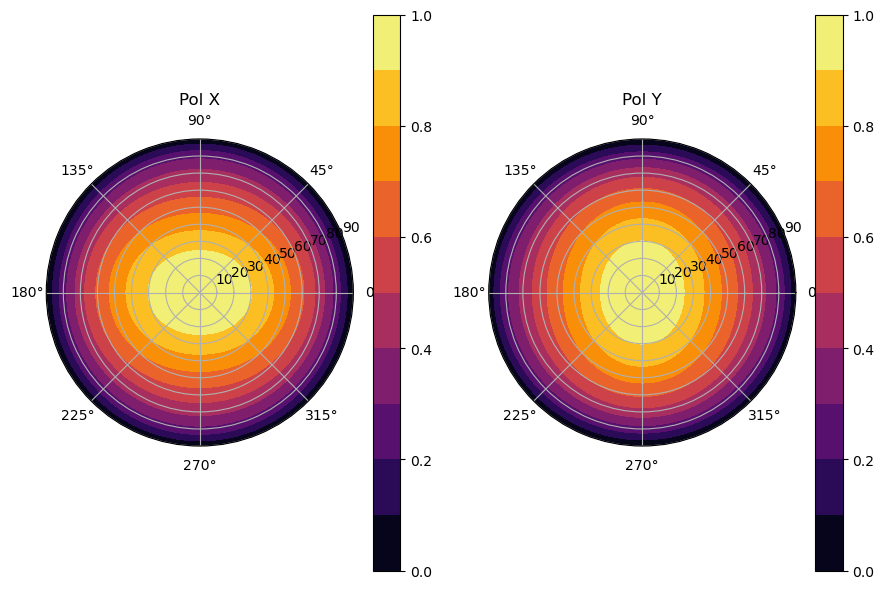

In [7]:
# Plot amplitude
fig, ax = plt.subplots(
    nrows=1,
    ncols=2,
    subplot_kw=dict(projection="polar"),
    figsize=(9, 6),
)
beam_amplitude_values = np.sqrt(
    np.abs(use_beam.data_array[0, :, :, :, :]) ** 2.0
    + np.abs(use_beam.data_array[1, :, :, :, :]) ** 2.0
)
for pol in range(beam.Nfeeds):
    contourplot = make_polar_contour_plot(
        ax[pol],
        (beam_amplitude_values[pol, 0, :, :]).T,
        np.radians(az_vals),
        za_vals,
        vmin=0,
        vmax=1,
    )
    fig.colorbar(contourplot, ax=ax[pol])
    ax[pol].set_title(f"Pol {feed_names[pol]}")
plt.tight_layout()
plt.show()

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.


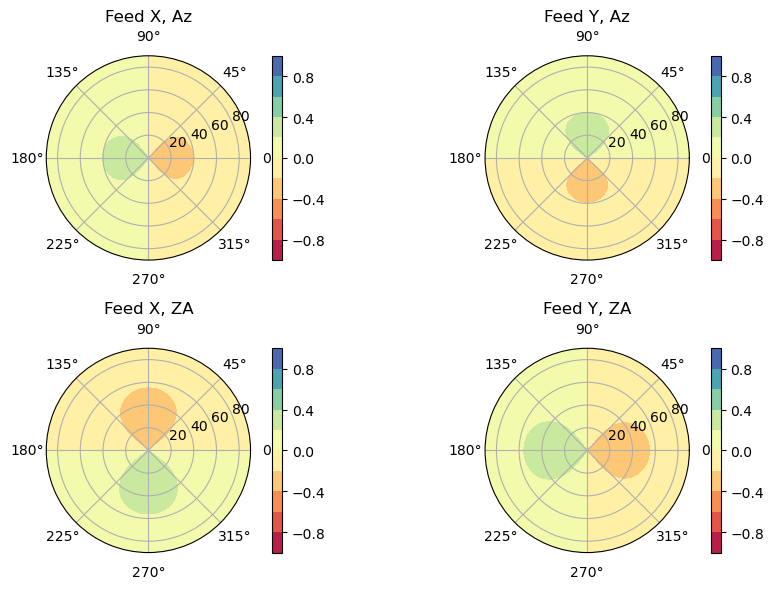

In [8]:
# Plot Jones matrix, real part
fig, ax = plt.subplots(
    nrows=2,
    ncols=2,
    subplot_kw=dict(projection="polar"),
    figsize=(9, 6),
)
for pol1 in range(beam.Naxes_vec):
    for pol2 in range(beam.Nfeeds):
        contourplot = make_polar_contour_plot(
            ax[pol1, pol2],
            np.real((use_beam.data_array[pol1, pol2, 0, :, :]).T),
            np.radians(az_vals),
            za_vals,
            vmin=-1,
            vmax=1,
        )
        fig.colorbar(contourplot, ax=ax[pol1, pol2])
        subtitle = f"Feed {feed_names[pol2]}, {sky_pol_names[pol1]}"
        ax[pol1, pol2].set_title(subtitle)
plt.tight_layout()
plt.show()

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.


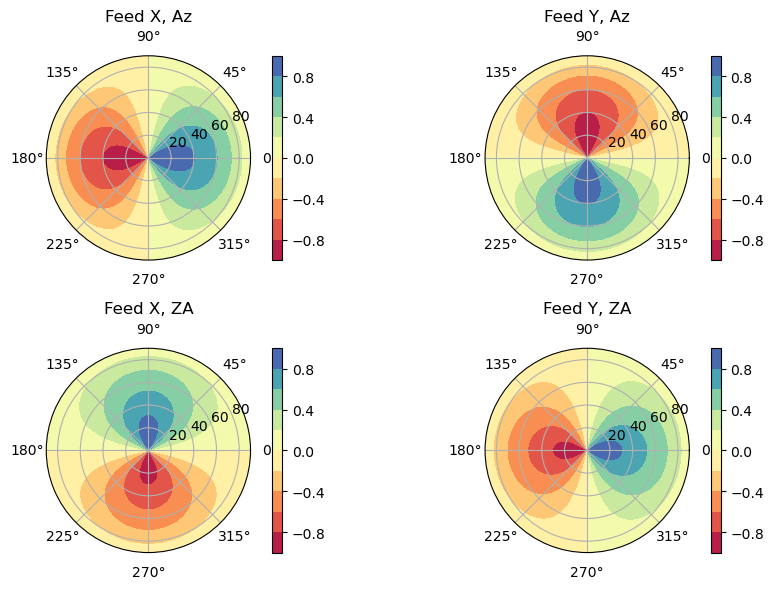

In [9]:
# Plot Jones matrix, imaginary part
fig, ax = plt.subplots(
    nrows=2,
    ncols=2,
    subplot_kw=dict(projection="polar"),
    figsize=(9, 6),
)
for pol1 in range(beam.Naxes_vec):
    for pol2 in range(beam.Nfeeds):
        contourplot = make_polar_contour_plot(
            ax[pol1, pol2],
            np.imag((use_beam.data_array[pol1, pol2, 0, :, :]).T),
            np.radians(az_vals),
            za_vals,
            vmin=-1,
            vmax=1,
        )
        fig.colorbar(contourplot, ax=ax[pol1, pol2])
        subtitle = f"Feed {feed_names[pol2]}, {sky_pol_names[pol1]}"
        ax[pol1, pol2].set_title(subtitle)
plt.tight_layout()
plt.show()